## Resnet model with 2 inputs: pose, image

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten, Reshape
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [19]:
BATCH_SIZE= 64
num_classes= 8

dict = {
     'Tesettür Elbise': [1, 0, 0, 0, 0, 0, 0, 0],
     'Tunik': [0, 1, 0, 0, 0, 0, 0, 0],
     'Şal':  [0, 0, 1, 0, 0, 0, 0, 0],
     'Eşarp': [0, 0, 0, 1, 0, 0, 0, 0],
     'Takım': [0, 0, 0, 0, 1, 0, 0, 0],
     "Kap / Pardesü":[0, 0, 0, 0, 0, 1, 0, 0],
     "Ferace":[0, 0, 0, 0, 0, 0, 1, 0],
     "T-shirt":[0, 0, 0, 0, 0, 0, 0, 1]
     }
#One hot encoding of labels

In [22]:
class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, list_pose, batch_size= BATCH_SIZE, dim=(32,32,32), n_channels= 1, n_classes=8, shuffle= True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_pose = list_pose
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.n = 0
    
    def __len__(self):
        return int(np.floor(len(self.list_pose) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_pose_temp = [self.list_pose[k] for k in indexes]

        i,p,l = self.__data_generation(list_pose_temp)
        return [i, p], l #image, pose, label

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_pose))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

    def __data_generation(self, list_pose_temp):   
        X = np.empty((self.batch_size, 66,1))
        Z = np.empty((self.batch_size, 135,100, 3))
        l = np.empty((self.batch_size, self.n_classes ))
        #X: poses   Z: Images   l: Labels   
        
        for i, each in enumerate(list_pose_temp):          
            X[i,] = np.reshape(np.load('C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/NPdata/'+ str(each[1]) +".npy", allow_pickle=True),(66,1))
            image = Image.open('C:/Users/IDU/Desktop/dataset/'+ str( each[1] )+ ".jpg")
            image = np.array( (image.convert('RGB')).resize((100,135)) )
            #print(each[2])
            
            Z[i,] = image / 255.0
            l[i,] = dict[ each[2]]
            
        return Z,X,l
    

In [1]:
params = {'dim': (32,32,32),
          'batch_size': BATCH_SIZE,
          'n_classes': num_classes,
          'n_channels': 1,
          'shuffle': False}

df = pd.read_csv(r"C:\Users\IDU\OneDrive - GTÜ\Desktop\TEZ\poses\Master_Thesis_Plus\resnet-8classes\out1.csv")

poselist = df.to_numpy() #contains productid and labels

# Generators
pose_generator = DataGenerator( poselist[:45000], **params) #train generator
val_generator = DataGenerator( poselist[45001:], **params)

NameError: name 'BATCH_SIZE' is not defined

________
## test

indexes  [0 1 2 3 4 5 6 7]
1168509 [0, 1, 0, 0, 0, 0, 0, 0]
7981329 [0, 0, 0, 0, 1, 0, 0, 0]
263823 [0, 0, 0, 0, 0, 1, 0, 0]
7978162 [1, 0, 0, 0, 0, 0, 0, 0]
7956976 [0, 0, 1, 0, 0, 0, 0, 0]
8083207 [0, 0, 0, 0, 0, 0, 0, 1]
7957097 [0, 0, 1, 0, 0, 0, 0, 0]
8058193 [0, 0, 0, 0, 0, 1, 0, 0]


array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.]])

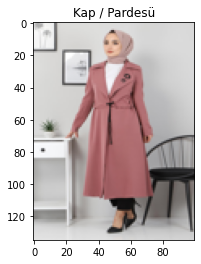

In [15]:
pose_generator.__getitem__(0)[1]

In [16]:
poselist[:8]

array([[3, 1168509, 'Tunik'],
       [5, 7981329, 'Takım'],
       [11, 263823, 'Kap / Pardesü'],
       [20, 7978162, 'Tesettür Elbise'],
       [40, 7956976, 'Şal'],
       [43, 8083207, 'T-shirt'],
       [45, 7957097, 'Şal'],
       [58, 8058193, 'Kap / Pardesü']], dtype=object)

_____

In [24]:
input_shape=(135,100,3) #image input shape
pose_shape = (66,1)
pose_input = tf.keras.layers.Input(pose_shape)

model = ResNet50( include_top= False , input_shape= input_shape , classes= num_classes)

x = GlobalAveragePooling2D()(model.output)
x = Dense(256, activation ='relu')(x)
x = Dense(66, activation ='relu')(x)
x= tf.expand_dims(x, axis= -1)

concat = tf.concat([x, pose_input], axis=1 )
concat = Flatten()(concat)

x = tf.keras.layers.Dense(32, activation= 'relu')(concat)

y = tf.keras.layers.Dense(num_classes)(x)

model = tf.keras.models.Model(inputs= [model.input, pose_input] , outputs= y)

In [25]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.listdir(checkpoint_dir)

[]

In [27]:
#model.load_weights(checkpoint_path)

In [28]:
model.compile( optimizer= "adam", loss='categorical_crossentropy', metrics= ['accuracy'] )

In [29]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                                 save_weights_only= True,
                                                 verbose= 1 )

In [30]:
history= model.fit(pose_generator, 
          validation_data= val_generator,
          batch_size= BATCH_SIZE,
          epochs= 5,
          callbacks= [cp_callback])

Epoch 1/5
703/703 [==============================] - ETA: 0s - loss: 7.8538 - accuracy: 0.1725 
Epoch 00001: saving model to training_1\cp.ckpt
703/703 [==============================] - 13910s 20s/step - loss: 7.8538 - accuracy: 0.1725 - val_loss: 7.5063 - val_accuracy: 0.2072
Epoch 2/5
703/703 [==============================] - ETA: 0s - loss: 7.5249 - accuracy: 0.1769 
Epoch 00002: saving model to training_1\cp.ckpt
703/703 [==============================] - 13779s 20s/step - loss: 7.5249 - accuracy: 0.1769 - val_loss: 7.4407 - val_accuracy: 0.2099
Epoch 3/5
703/703 [==============================] - ETA: 0s - loss: 7.5249 - accuracy: 0.1769 
Epoch 00003: saving model to training_1\cp.ckpt
703/703 [==============================] - 13880s 20s/step - loss: 7.5249 - accuracy: 0.1769 - val_loss: 7.4366 - val_accuracy: 0.2097
Epoch 4/5
703/703 [==============================] - ETA: 0s - loss: 7.5249 - accuracy: 0.1769 
Epoch 00004: saving model to training_1\cp.ckpt
703/703 [==========

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')
model.save_weights("C:/Users/IDU/OneDrive - GTÜ/Desktop/TEZ/poses/Master_Thesis_Plus/pretrained_weights_8class.h5")

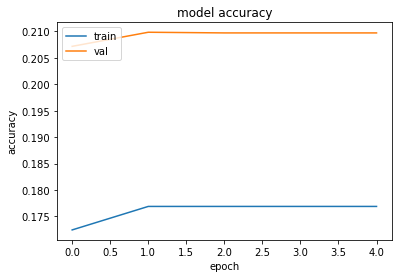

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.savefig('model_accuracy.png')
plt.show()


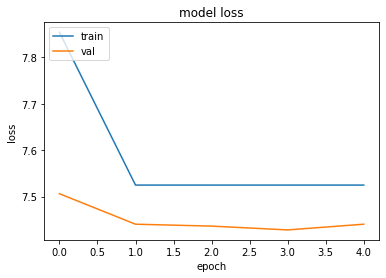

In [32]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()


In [34]:
model.save('model_poseResnet.h5')